# Polish companies bankruptcy data
## https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn as skl
import xgboost as xgb
import seaborn as sb
import matplotlib.pyplot as plt
import subprocess

plt.rcParams['figure.figsize'] = [16, 9]

## Read data

In [2]:
r = subprocess.run(['ls'], stdout=subprocess.PIPE)
all_files = str(r.stdout, encoding='utf-8')[:-1].split('\n')
data_files = []
for el in all_files:
    if el.endswith('.arff'):
        data_files.append(el)
print("Dataset files:", data_files)

columns = '''X1 net profit / total assets
X2 total liabilities / total assets
X3 working capital / total assets
X4 current assets / short-term liabilities
X5 ((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365
X6 retained earnings / total assets
X7 EBIT / total assets
X8 book value of equity / total liabilities
X9 sales / total assets
X10 equity / total assets
X11 (gross profit + extraordinary items + financial expenses) / total assets
X12 gross profit / short-term liabilities
X13 (gross profit + depreciation) / sales
X14 (gross profit + interest) / total assets
X15 (total liabilities * 365) / (gross profit + depreciation)
X16 (gross profit + depreciation) / total liabilities
X17 total assets / total liabilities
X18 gross profit / total assets
X19 gross profit / sales
X20 (inventory * 365) / sales
X21 sales (n) / sales (n-1)
X22 profit on operating activities / total assets
X23 net profit / sales
X24 gross profit (in 3 years) / total assets
X25 (equity - share capital) / total assets
X26 (net profit + depreciation) / total liabilities
X27 profit on operating activities / financial expenses
X28 working capital / fixed assets
X29 logarithm of total assets
X30 (total liabilities - cash) / sales
X31 (gross profit + interest) / sales
X32 (current liabilities * 365) / cost of products sold
X33 operating expenses / short-term liabilities
X34 operating expenses / total liabilities
X35 profit on sales / total assets
X36 total sales / total assets
X37 (current assets - inventories) / long-term liabilities
X38 constant capital / total assets
X39 profit on sales / sales
X40 (current assets - inventory - receivables) / short-term liabilities
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
X42 profit on operating activities / sales
X43 rotation receivables + inventory turnover in days
X44 (receivables * 365) / sales
X45 net profit / inventory
X46 (current assets - inventory) / short-term liabilities
X47 (inventory * 365) / cost of products sold
X48 EBITDA (profit on operating activities - depreciation) / total assets
X49 EBITDA (profit on operating activities - depreciation) / sales
X50 current assets / total liabilities
X51 short-term liabilities / total assets
X52 (short-term liabilities * 365) / cost of products sold)
X53 equity / fixed assets
X54 constant capital / fixed assets
X55 working capital
X56 (sales - cost of products sold) / sales
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
X58 total costs / total sales
X59 long-term liabilities / equity
X60 sales / inventory
X61 sales / receivables
X62 (short-term liabilities *365) / sales
X63 sales / short-term liabilities
X64 sales / fixed assets'''

columns = [el[(3 + int(i >= 9)):] for i, el in enumerate(columns.split('\n'))] + ['bankruptcy']

original_data = pd.read_csv(
    data_files[2], skiprows=69, header=None,
    names=columns, na_values='?', dtype=np.float32
)

original_data[['bankruptcy']] = original_data[['bankruptcy']].astype(np.int32)

print('\nData shape (3th year subset):', original_data.shape)


def count_classes(data_frame):
    cls_counts = data_frame[['bankruptcy']].value_counts()
    print('Bankruptcy percent: {}%'.format(round(int(cls_counts[1]) / (sum(cls_counts)) * 100, 2)))

count_classes(original_data)


def print_df_nan_counts(data_frame):
    nans = [sum(data_frame[col].isna() / data_frame.shape[0] * 100) for col in list(data_frame.columns)]
    nans = [str(round(nan, 3)) + ' %' for nan in nans]
    print(nans)


def print_df_inf_cols(data_frame, verbose=False):
    infc_all = 0
    for col in list(data_frame.columns):
        inf_count = (data_frame[col] == np.inf).mean()
        if inf_count > 0:
            infc_all += 1
            if verbose:
                print(col, inf_count)
    print(infc_all)


print('\nNaN count in features:')
print_df_nan_counts(original_data)
print('\nFeatures with Inf.:')
print_df_inf_cols(original_data, verbose=True)

Dataset files: ['1year.arff', '2year.arff', '3year.arff', '4year.arff', '5year.arff']

Data shape (3th year subset): (10503, 65)
Bankruptcy percent: 4.71%

NaN count in features:
['0.0 %', '0.0 %', '0.0 %', '0.171 %', '0.238 %', '0.0 %', '0.0 %', '0.133 %', '0.029 %', '0.0 %', '0.0 %', '0.171 %', '0.409 %', '0.0 %', '0.076 %', '0.133 %', '0.133 %', '0.0 %', '0.409 %', '0.409 %', '7.684 %', '0.0 %', '0.409 %', '2.161 %', '0.0 %', '0.133 %', '6.808 %', '2.171 %', '0.0 %', '0.409 %', '0.409 %', '0.962 %', '0.171 %', '0.133 %', '0.0 %', '0.0 %', '45.092 %', '0.0 %', '0.409 %', '0.171 %', '1.923 %', '0.409 %', '0.409 %', '0.409 %', '5.627 %', '0.171 %', '0.819 %', '0.0 %', '0.409 %', '0.133 %', '0.0 %', '0.819 %', '2.171 %', '2.171 %', '0.0 %', '0.409 %', '0.0 %', '0.276 %', '0.0 %', '5.636 %', '0.162 %', '0.409 %', '0.171 %', '2.171 %', '0.0 %']

Features with Inf.:
0


## Data preprocessing and feature engineering

In [3]:
def gen_new_columns(col1, col2):
    col1, col2 = col1.split(' / '), col2.split(' / ')
    if len(col1) != 2 or len(col2) != 2:
        return ''
    if col1[1] == col2[1]:
        return col1[0] + ' / ' + col2[0]
    return ''


def fill_nan_inf(data_frame, nan=True, inf=False):
    if nan:
        data_frame.fillna(data_frame.median(axis=0), axis=0, inplace=True)
    if inf:
        for col in list(data_frame.columns):
            data_frame[col] = data_frame[col].replace(np.inf, data_frame[col].median())


def remove_outliers(data_frame, lower_bound=0.0025, upper_bound=0.9975, y_label=-1, y=None):
    if y_label == -1:
        cols = list(data_frame.columns)[:-1]
    else:
        cols = list(data_frame.columns)
    selection = [(data_frame[col] < data_frame[col].quantile(lower_bound)) \
                 | (data_frame[col] > data_frame[col].quantile(upper_bound)) for col in cols]
    rows_to_drop = selection[0]
    for sel in selection[1:]:
        rows_to_drop |= sel
    rows_to_drop = data_frame[rows_to_drop].index
    if y is None:
        return data_frame.drop(rows_to_drop)
    else:
        return data_frame.drop(rows_to_drop), y.drop(rows_to_drop)


preprocessed_data = original_data.copy()

for i, el_i in enumerate(columns):
    for j, el_j in enumerate(columns):
        if i == j:
            continue
        new_col = gen_new_columns(el_i, el_j)
        if new_col != '':
            preprocessed_data[new_col] = preprocessed_data[el_i] / preprocessed_data[el_j]

preprocessed_data = remove_outliers(preprocessed_data, lower_bound=0.0025, upper_bound=0.9975)
fill_nan_inf(preprocessed_data, inf=True)

for col in list(preprocessed_data.columns):
    if not np.isfinite(preprocessed_data[col]).all():
        del preprocessed_data[col]

print('New data shape:', preprocessed_data.shape)
print('\nNew classes balance:')
count_classes(preprocessed_data)
old_n_rows = original_data.shape[0]
new_n_rows = preprocessed_data.shape[0]
print('\nSamples loss percent after preprocessing: {}%'.format(round((old_n_rows - new_n_rows) / old_n_rows * 100, 2)))

preprocessed_data = preprocessed_data.sample(frac=1.0, random_state=42)
y = preprocessed_data[['bankruptcy']]
preprocessed_data = preprocessed_data.drop(columns=['bankruptcy'])

New data shape: (8170, 476)

New classes balance:
Bankruptcy percent: 4.19%

Samples loss percent after preprocessing: 22.21%


## Random forest

In [4]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


def train_test_scores(alg_instance, x, y, scores_dict, test_size=0.25):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=True, random_state=42)
    alg_instance.fit(train_x, train_y)

    train_pred_y = alg_instance.predict(train_x)
    test_pred_y = alg_instance.predict(test_x)

    test_y = test_y.to_numpy().ravel()
    train_y = train_y.to_numpy().ravel()

    res = {'train': {}, 'test': {}}
    for score_name in scores_dict.keys():
        train_score_value = scores_dict[score_name](train_y, train_pred_y)
        test_score_value = scores_dict[score_name](test_y, test_pred_y)

        train_score_value, test_score_value = round(train_score_value, 6), round(test_score_value, 6)
        
        res['train'][score_name] = train_score_value
        res['test'][score_name] = test_score_value

    return res


def show_dep_on_param(alg_class, x, y, fixed_params, param_name, param_values, scores_dict):
    scores = {'train': {}, 'test': {}}
    for score_name in scores_dict.keys():
        scores['train'][score_name] = []
        scores['test'][score_name] = []
    if isinstance(alg_class(), RandomForestClassifier):
        scores['OOB'] = []

    for par_val in param_values:
        params = fixed_params.copy()
        params.update({param_name: par_val})

        alg = alg_class(**params)
        new_scores = train_test_scores(alg, x, y, scores_dict)
        for set_key in new_scores.keys():
            for score_name in new_scores[set_key].keys():
                scores[set_key][score_name].append(new_scores[set_key][score_name])
        if isinstance(alg, RandomForestClassifier):
            scores['OOB'].append(round(alg.oob_score_, 6))

    mpl_colors = [
        'limegreen', 'darkgreen',
        'skyblue', 'steelblue',
        'orangered', 'darkred',
        'grey'
    ]

    for score_name in scores['train'].keys():
        for set_key in scores.keys():
            if set_key == 'OOB':
                continue
            plt.plot(param_values, scores[set_key][score_name], '.-m',
                     label = f'{set_key}ing {score_name}', color=mpl_colors.pop(0))
    if isinstance(alg, RandomForestClassifier):
        plt.plot(param_values, scores['OOB'], '.-m',
                 label = 'Out-Of-Bound', color=mpl_colors.pop(0))
    plt.xlabel(param_name, fontsize=24)
    plt.ylabel('Scores', fontsize=24)
    plt.legend(loc = 'lower right', fontsize=16)
    plt.show()


scores_func = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score
}

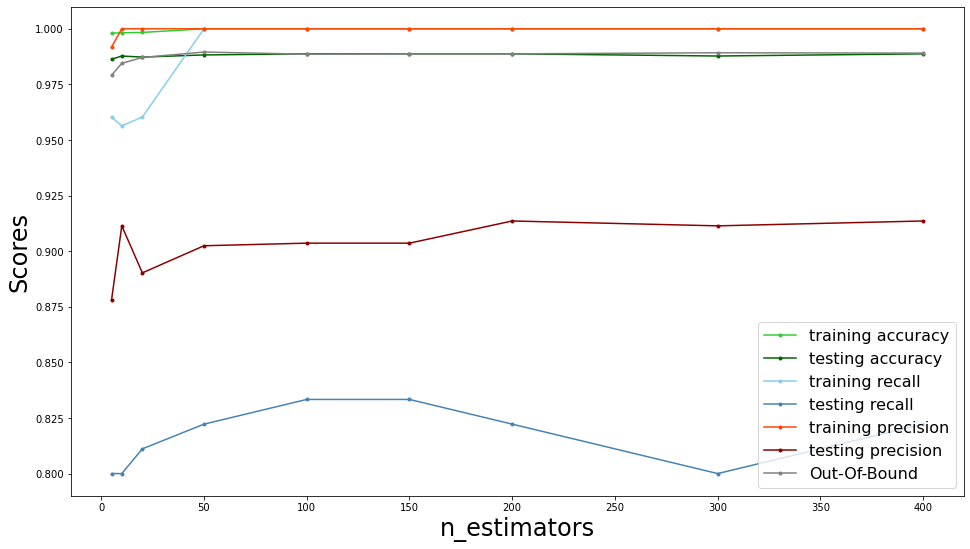

In [5]:
rf_params = {
    'max_features': 0.33,
    'oob_score': True,
    'n_jobs': 8,
    'random_state': 42
}

show_dep_on_param(RandomForestClassifier, preprocessed_data, y,
                  rf_params, 'n_estimators', [5, 10, 20, 50, 100, 150, 200, 300, 400], scores_func)

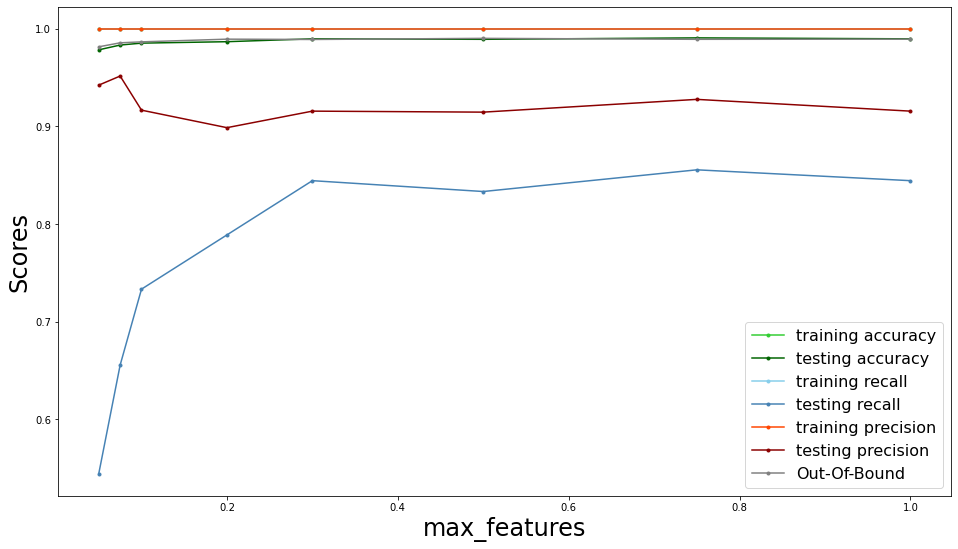

In [6]:
from math import sqrt, ceil

rf_params = {
    'n_estimators': 150,
    'oob_score': True,
    'n_jobs': 8,
    'random_state': 42
}

show_dep_on_param(RandomForestClassifier, preprocessed_data, y,
                  rf_params, 'max_features', [0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0], scores_func)

## XGBoost Classifier

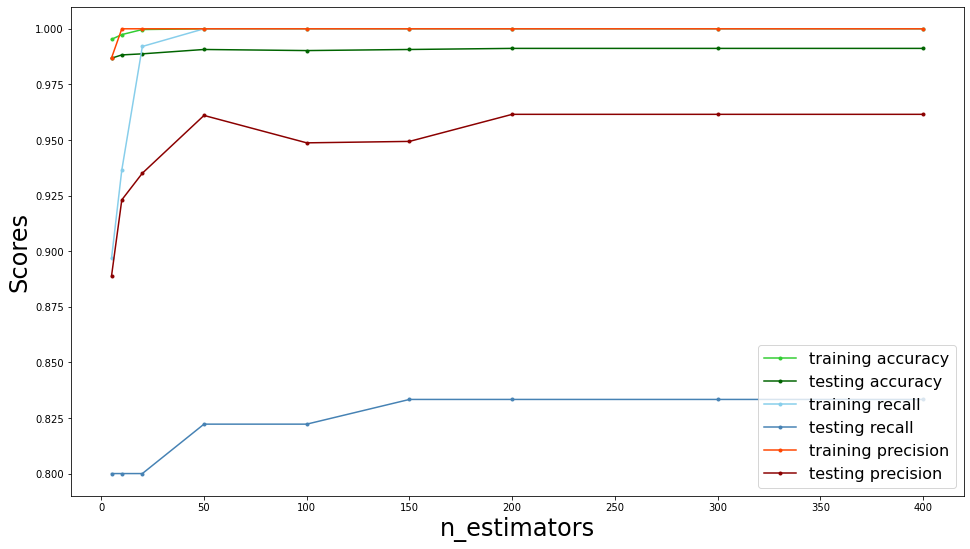

In [7]:
gbt_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_jobs': 8,
    'random_state': 42
}

show_dep_on_param(xgb.XGBClassifier, preprocessed_data, y,
                  gbt_params, 'n_estimators', [5, 10, 20, 50, 100, 150, 200, 300, 400], scores_func)

# Comparison of classification algorithms

Best kNN precision and recall scores: ~0.2


Best MLP precision and recall scores: ~0.6


Best Random Forest precision: 0.9

Best Random Forest recall: 0.825


Best XGBoost precision: ~0.95

Best XGBoost recall: ~0.825

## Clustering

In [21]:
from sklearn.cluster import KMeans, DBSCAN


def normalize_data(data_frame):
    return (data_frame - data_frame.mean(axis = 0)) / data_frame.std(axis = 0)


def search_for_bankruptcy_cluster(labels, y):
    n_samples = y.shape[0]
    if labels.shape[0] != n_samples:
        raise ValueError
    n_bankrupts = y['bankruptcy'].value_counts()[1]
    y_np = y['bankruptcy'].to_numpy()

    cluster_sizes = labels.value_counts()
    cluster_nums = list(labels.unique())
    print('N clusters:', len(cluster_nums))
    print('Cluster indices:', cluster_nums)
    for cluster_num in cluster_nums:
        cls_count = 0
        bnk_count = 0
        for i in range(labels.shape[0]):
            if labels[i] == cluster_num:
                cls_count += 1
                if y_np[i] == 1:
                    bnk_count += 1
        print(f'Cluster {cluster_num} ({cls_count} points / {round(100 * cls_count / n_samples, 2)} % of points) contains {bnk_count} bankrupts ({round(100 * bnk_count / n_bankrupts, 2)} %)')


norm_data = normalize_data(preprocessed_data)
for col in list(norm_data.columns):
    if not np.isfinite(norm_data[col]).all():
        del norm_data[col]

## KMeans

In [32]:
for k in [2, 5, 10, 16]:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42)
    kmeans_labels = kmeans.fit_predict(norm_data)
    kmeans_labels = pd.Series(kmeans_labels)
    search_for_bankruptcy_cluster(kmeans_labels, y)
    print()

N clusters: 2
Cluster indices: [1, 0]
Cluster 1 (6160 points / 75.4 % of points) contains 314 bankrupts (91.81)
Cluster 0 (2010 points / 24.6 % of points) contains 28 bankrupts (8.19)

N clusters: 5
Cluster indices: [0, 3, 1, 2, 4]
Cluster 0 (5964 points / 73.0 % of points) contains 192 bankrupts (56.14)
Cluster 3 (273 points / 3.34 % of points) contains 11 bankrupts (3.22)
Cluster 1 (1284 points / 15.72 % of points) contains 129 bankrupts (37.72)
Cluster 2 (646 points / 7.91 % of points) contains 10 bankrupts (2.92)
Cluster 4 (3 points / 0.04 % of points) contains 0 bankrupts (0.0)

N clusters: 10
Cluster indices: [5, 4, 0, 2, 9, 3, 6, 1, 7, 8]
Cluster 5 (4034 points / 49.38 % of points) contains 122 bankrupts (35.67)
Cluster 4 (94 points / 1.15 % of points) contains 5 bankrupts (1.46)
Cluster 0 (1217 points / 14.9 % of points) contains 27 bankrupts (7.89)
Cluster 2 (634 points / 7.76 % of points) contains 48 bankrupts (14.04)
Cluster 9 (983 points / 12.03 % of points) contains 106 ba

## DBSCAN

In [31]:
for eps in [0.01, 0.1, 1, 5, 10, 50, 100]:
    for min_samples in [5, 20, 100]:
        print('EPS =', eps, ', MIN_SAPLES =', min_samples, '\n')
        dbscan = DBSCAN(eps=eps, min_samples=5, n_jobs=8)
        dbscan_labels = dbscan.fit_predict(norm_data)
        dbscan_labels = pd.Series(dbscan_labels)
        search_for_bankruptcy_cluster(dbscan_labels, y)
        print('\n')

EPS = 0.01 , MIN_SAPLES = 5 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (100.0)


EPS = 0.01 , MIN_SAPLES = 20 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (100.0)


EPS = 0.01 , MIN_SAPLES = 100 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (100.0)


EPS = 0.1 , MIN_SAPLES = 5 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (100.0)


EPS = 0.1 , MIN_SAPLES = 20 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (100.0)


EPS = 0.1 , MIN_SAPLES = 100 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (100.0)


EPS = 1 , MIN_SAPLES = 5 

N clusters: 1
Cluster indices: [-1]
Cluster -1 (8170 points / 100.0 % of points) contains 342 bankrupts (1

## AgglomerativeClustering

In [35]:
from sklearn.cluster import AgglomerativeClustering

for k in [2, 5, 10]:
    agcls = AgglomerativeClustering(n_clusters=k)
    agcls_labels = agcls.fit_predict(norm_data)
    agcls_labels = pd.Series(agcls_labels)
    search_for_bankruptcy_cluster(agcls_labels, y)
    print()

N clusters: 2
Cluster indices: [0, 1]
Cluster 0 (6756 points / 82.69 % of points) contains 215 bankrupts (62.87)
Cluster 1 (1414 points / 17.31 % of points) contains 127 bankrupts (37.13)

N clusters: 5
Cluster indices: [0, 2, 1, 3, 4]
Cluster 0 (6543 points / 80.09 % of points) contains 212 bankrupts (61.99)
Cluster 2 (103 points / 1.26 % of points) contains 3 bankrupts (0.88)
Cluster 1 (1414 points / 17.31 % of points) contains 127 bankrupts (37.13)
Cluster 3 (107 points / 1.31 % of points) contains 0 bankrupts (0.0)
Cluster 4 (3 points / 0.04 % of points) contains 0 bankrupts (0.0)

N clusters: 10
Cluster indices: [4, 5, 2, 1, 3, 9, 7, 0, 8, 6]
Cluster 4 (4174 points / 51.09 % of points) contains 147 bankrupts (42.98)
Cluster 5 (102 points / 1.25 % of points) contains 3 bankrupts (0.88)
Cluster 2 (1860 points / 22.77 % of points) contains 31 bankrupts (9.06)
Cluster 1 (1188 points / 14.54 % of points) contains 102 bankrupts (29.82)
Cluster 3 (498 points / 6.1 % of points) contains 3